In [1]:
%load_ext autoreload
%autoreload 2

import transformers
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import tensorflow_text
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import swifter
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
tf.test.is_gpu_available()

True

### 0. Load cvs data and assign label

In [3]:
df_train = pd.read_csv('Corona_NLP_train.csv', header=0)
df_test = pd.read_csv('Corona_NLP_test.csv', header=0)

In [4]:
df_train.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [5]:
df_train.dropna(subset=['Sentiment'],inplace=True)
df_train.isnull().sum()

UserName            0
ScreenName          0
Location         2563
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
def assign_label(x):
    if 'Negative' in x:
        return 'Negative'
    elif 'Positive' in x:
        return 'Positive'
    else:
        return 'Neutral'

df_train['Label'] = df_train['Sentiment'].apply(lambda x: assign_label(x))
df_test['Label'] = df_test['Sentiment'].apply(lambda x: assign_label(x))

### 1. Clean text - remove punctuation

In [7]:
def clean_text(x):
    x = re.sub(r'[^\w\s]|\n+', ' ', x).lower().strip()
    x = re.sub('_', ' ',x)
    x = re.sub('\s+', ' ',x)
    return x

df_train['clean_text'] = df_train['OriginalTweet'].swifter.apply(lambda x: clean_text(x))
df_test['clean_text'] = df_test['OriginalTweet'].swifter.apply(lambda x: clean_text(x))

Pandas Apply:   0%|          | 0/12129 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3798 [00:00<?, ?it/s]

### 2. Sentiment classification - BERT

#### 2.1 Prepare data with Token id, mask and segment

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [9]:
corpus = df_train["clean_text"].tolist()
maxlen = 140
## add special tokens
maxqnans = np.int((maxlen-10)) # number of strings are retained
corpus_tokenized = ["[CLS] "+ " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
                   " [SEP]" for txt in corpus]

## generate masks: 1 for text and 0 for additional non-text (fixed length)
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
## generate idx
idx = [tokenizer.encode(seq.split(" "))[1:-1] for seq in txt2seq] # tokenizer.encode automatically add [CLS] (101) and [SEP] (102) on the basis of text

In [10]:
print(df_train.shape, len(corpus_tokenized), len(masks), maxqnans)
print(corpus_tokenized[0:2], '\n', masks[0:2], '\n', txt2seq[0:2], '\n', idx[0:2])

(12129, 8) 12129 12129 130
['[CLS] men ##yr ##bie phil ga ##han chris ##it ##v https t co if ##z ##9 ##fan ##2 ##pa and https t co xx ##6 ##gh ##gf ##z ##cc and https t co i ##2 ##nl ##zd ##x ##no ##8 [SEP]', '[CLS] advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if po ##ss adequate supplies of regular med ##s but not over order [SEP]'] 
 [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [11]:
print(idx[0:2], '\n','\n', masks[0:2])

[[101, 2273, 12541, 11283, 6316, 11721, 4819, 3782, 4183, 2615, 16770, 1056, 2522, 2065, 2480, 2683, 15143, 2475, 4502, 1998, 16770, 1056, 2522, 22038, 2575, 5603, 25708, 2480, 9468, 1998, 16770, 1056, 2522, 1045, 2475, 20554, 26494, 2595, 3630, 2620, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 6040, 2831, 2000, 2115, 14754, 2155, 2000, 3863, 3042, 3616, 3443, 3967, 2862, 2007, 3042, 3616, 1997, 14754, 2816, 11194, 15535, 14246, 2275, 2039, 3784, 6023, 6115, 2065, 13433, 4757, 11706, 6067, 1997, 3180, 19960, 2015, 2021, 2025, 2058, 2344, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [16]:
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32')]

## label
y_train = df_train['Label'].values

In [13]:
print(X_train[0][0], X_train[1][0])

[  101  2273 12541 11283  6316 11721  4819  3782  4183  2615 16770  1056
  2522  2065  2480  2683 15143  2475  4502  1998 16770  1056  2522 22038
  2575  5603 25708  2480  9468  1998 16770  1056  2522  1045  2475 20554
 26494  2595  3630  2620   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

#### 2.2 Response label encoder

In [17]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [18]:
print(dic_y_mapping)
print(inverse_dic)

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}
{'Negative': 0, 'Neutral': 1, 'Positive': 2}


#### 2.3 Model preparation 

In [22]:
## inputs
idx = layers.Input((140), dtype="int32", name="input_idx")
masks = layers.Input((140), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
# Load pretrained model
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0] # Output from bert layer
## fine-tuning (dense layer)
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
## define trainable layers
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
## compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 140)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti TFBaseModelOutput(la 66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 768)          0           tf_distil_bert_model_2[0][0

#### 2.4 Model training

In [25]:
tf.config.run_functions_eagerly(True)
## train
training = model.fit(x=X_train, y=y_train, batch_size=64, epochs=30, shuffle=True, verbose=1, validation_split=0.3)

Epoch 1/30
133/133 [==============================] - 138s 1s/step - loss: 0.6928 - accuracy: 0.6949 - val_loss: 0.7857 - val_accuracy: 0.6587
Epoch 2/30
133/133 [==============================] - 138s 1s/step - loss: 0.6788 - accuracy: 0.7071 - val_loss: 0.7801 - val_accuracy: 0.6587
Epoch 3/30
133/133 [==============================] - 138s 1s/step - loss: 0.6800 - accuracy: 0.7075 - val_loss: 0.7755 - val_accuracy: 0.6625
Epoch 4/30
133/133 [==============================] - 138s 1s/step - loss: 0.6721 - accuracy: 0.7115 - val_loss: 0.7975 - val_accuracy: 0.6538
Epoch 5/30
133/133 [==============================] - 138s 1s/step - loss: 0.6652 - accuracy: 0.7128 - val_loss: 0.7880 - val_accuracy: 0.6565
Epoch 6/30
133/133 [==============================] - 138s 1s/step - loss: 0.6589 - accuracy: 0.7211 - val_loss: 0.7904 - val_accuracy: 0.6518
Epoch 7/30
133/133 [==============================] - 138s 1s/step - loss: 0.6590 - accuracy: 0.7166 - val_loss: 0.7933 - val_accuracy: 0.6535

#### 2.5 Validation trained model on training data

In [85]:
corpus_test = df_test["clean_text"].tolist()
maxlen = 140
## add special tokens
maxqnans = np.int(maxlen-10) # number of strings are retained
corpus_tokenized_test = ["[CLS] "+ " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
                         " [SEP]" for txt in corpus_test]
# corpus_tokenized = [" ".join(tokenizer.tokenize(str(txt))[:maxqnans]) for txt in corpus]
## generate masks
masks_test = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized_test]
## padding
txt2seq_test = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized_test]

## generate idx
idx_test = [tokenizer.encode(seq.split(" "))[1:-1] for seq in txt2seq_test] # tokenizer.encode automatically add [CLS] (101) and [SEP] (102) on the basis of text

## generate segments
segments_test = [] 
for seq in txt2seq_test:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_test = [np.asarray(idx_test, dtype='int32'), 
           np.asarray(masks_test, dtype='int32')]

In [86]:
## test
predicted_prob = model1.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

Accuracy: 0.64
Auc: 0.8
Detail:
              precision    recall  f1-score   support

    Negative       0.64      0.72      0.68      1633
     Neutral       0.59      0.42      0.49       619
    Positive       0.65      0.65      0.65      1546

    accuracy                           0.64      3798
   macro avg       0.63      0.59      0.61      3798
weighted avg       0.64      0.64      0.64      3798



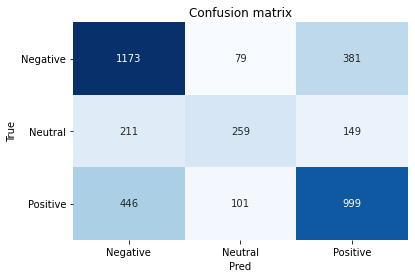

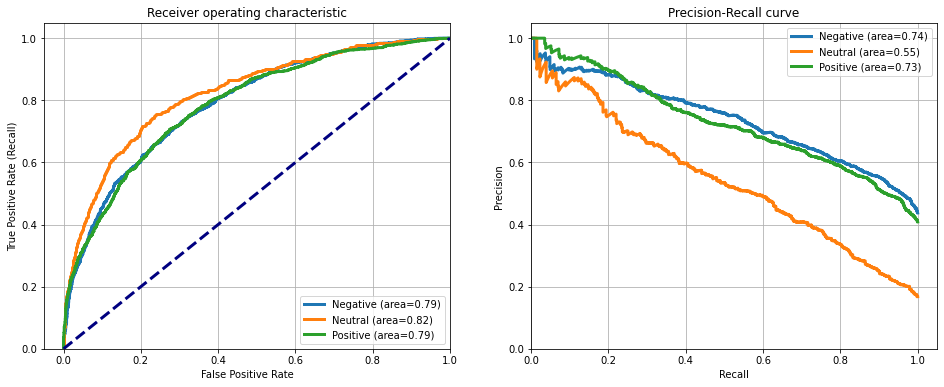

In [87]:
y_test = df_test['Label'].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,6))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [26]:
model.save_weights('trained_model/light_version/light_bert_weights')

In [70]:
model1.load_weights('trained_model/light_version/light_bert_weights')

### 3. BERT - smaller version

In [27]:
df_train = pd.read_csv('Corona_NLP_train.csv', header=0)
df_test = pd.read_csv('Corona_NLP_test.csv', header=0)
df_train.dropna(subset=['Sentiment'],inplace=True)
df_train.isnull().sum()

UserName            0
ScreenName          0
Location         2563
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [28]:
def assign_label(x):
    if 'Negative' in x:
        return 'Negative'
    elif 'Positive' in x:
        return 'Positive'
    else:
        return 'Neutral'

df_train['Sentiment'] = df_train['Sentiment'].apply(lambda x: assign_label(x))
df_test['Sentiment'] = df_test['Sentiment'].apply(lambda x: assign_label(x))

In [29]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [30]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(
        shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [31]:
train, valid = train_test_split(df_train, train_size=0.7, random_state=0, stratify=df_train['Sentiment'])
y_train, X_train = train['Sentiment'], train.drop(['Sentiment'], axis=1)
y_valid, X_valid = valid['Sentiment'], valid.drop(['Sentiment'], axis=1)
y_train_c = tf.keras.utils.to_categorical(y_train.astype('category').cat.codes.values, num_classes=3)
y_valid_c = tf.keras.utils.to_categorical(y_valid.astype('category').cat.codes.values, num_classes=3)

In [32]:
classifier_model = build_classifier_model()

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1, Total size: 115.55MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 5 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [52]:
X_train.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet
2653,6452,51404,NaN,18-03-2020,@Sideshow_JaneV3 Perhaps... I think the world ...
10436,14235,59187,"ÜT: 48.931022,2.244642",20-03-2020,Ok. So everyone has gone nuts for bog roll but...
3093,6892,51844,NaN,18-03-2020,"Just saw that amazon has to hire 100,000 addit..."


In [58]:
checkpoint_path = "trained_model/cp.ckpt"
os.path.dirname(checkpoint_path)

'trained_model/light_version'

In [62]:
checkpoint_path = "trained_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [34]:
history = classifier_model.fit(x=X_train['OriginalTweet'].values, y=y_train_c, 
                               validation_data=(X_valid['OriginalTweet'].values, y_valid_c), epochs=20)

Epoch 1/20
266/266 [==============================] - 67s 253ms/step - loss: 0.3704 - accuracy: 0.8684 - val_loss: 0.5594 - val_accuracy: 0.7980
Epoch 2/20
266/266 [==============================] - 67s 251ms/step - loss: 0.3438 - accuracy: 0.8771 - val_loss: 0.5708 - val_accuracy: 0.7980
Epoch 3/20
266/266 [==============================] - 67s 252ms/step - loss: 0.3274 - accuracy: 0.8852 - val_loss: 0.5735 - val_accuracy: 0.8032
Epoch 4/20
266/266 [==============================] - 67s 251ms/step - loss: 0.3149 - accuracy: 0.8893 - val_loss: 0.5713 - val_accuracy: 0.8049
Epoch 5/20
266/266 [==============================] - 67s 250ms/step - loss: 0.3086 - accuracy: 0.8909 - val_loss: 0.5775 - val_accuracy: 0.8043
Epoch 6/20
266/266 [==============================] - 67s 250ms/step - loss: 0.2897 - accuracy: 0.8981 - val_loss: 0.5821 - val_accuracy: 0.8016
Epoch 7/20
266/266 [==============================] - 67s 250ms/step - loss: 0.2769 - accuracy: 0.9022 - val_loss: 0.5882 - val_ac

In [ ]:
# classifier_model.save_weights('trained_model/small_version/small_bert_weights')
## test
predicted_prob = classifier_model.predict(X_valid['OriginalTweet'].values)
predicted = [np.argmax(pred) for pred in predicted_prob]

In [35]:
classifier_model.save_weights('trained_model/small_version/small_bert_weights')

In [65]:
model1 = build_classifier_model()
model1.load_weights(checkpoint_path)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

### 4. CatBoost

In [66]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=5000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs)
    return model.fit(train_pool, eval_set=test_pool, verbose=100, plot=True, use_best_model=True)

In [57]:
X_train.reset_index(drop=True).loc[0:4]

,UserName,ScreenName,Location,TweetAt,OriginalTweet
0,6452,51404,NaN,18-03-2020,@Sideshow_JaneV3 Perhaps... I think the world ...
1,14235,59187,"ÜT: 48.931022,2.244642",20-03-2020,Ok. So everyone has gone nuts for bog roll but...
2,6892,51844,NaN,18-03-2020,"Just saw that amazon has to hire 100,000 addit..."
3,6530,51482,"Arcadia, Ca",18-03-2020,I m standing in line with more than 50 people ...
4,7715,52667,NaN,18-03-2020,#Verizon sent us to an empty store and risk ge...


In [67]:
train_pool = Pool(data=X_train[['UserName', 'ScreenName', 'OriginalTweet']], label=y_train, text_features=['OriginalTweet'])
valid_pool = Pool(data=X_valid[['UserName', 'ScreenName', 'OriginalTweet']], label=y_valid, text_features=['OriginalTweet'])

In [68]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4799764	test: 0.4762297	best: 0.4762297 (0)	total: 16.2ms	remaining: 1m 20s
100:	learn: 0.7707892	test: 0.7153064	best: 0.7153064 (100)	total: 829ms	remaining: 40.2s
200:	learn: 0.8114252	test: 0.7221764	best: 0.7235504 (196)	total: 1.41s	remaining: 33.6s
300:	learn: 0.8401649	test: 0.7315196	best: 0.7331685 (295)	total: 1.97s	remaining: 30.8s
400:	learn: 0.8638398	test: 0.7375653	best: 0.7400385 (382)	total: 2.55s	remaining: 29.3s
500:	learn: 0.8779741	test: 0.7416873	best: 0.7455345 (471)	total: 3.11s	remaining: 28s
600:	learn: 0.8908127	test: 0.7444353	best: 0.7455345 (471)	total: 3.69s	remaining: 27.1s
700:	learn: 0.9038869	test: 0.7441605	best: 0.7466337 (634)	total: 4.3s	remaining: 26.4s
800:	learn: 0.9138987	test: 0.7405881	best: 0.7466337 (634)	total: 4.88s	remaining: 25.6s
900:	learn: 0.9250883	test: 0.7436109	best: 0.7466337 (634)	total: 5.51s	remaining: 25.1s
1000:	learn: 0.9365135	test: 0.7430613	best: 0.7466337 (634)	total: 6.12s	remaining: 24.5s
1100:	learn: 0